# FrozenLake Q-Learning 훈련 및 평가

## 학습 목표
- Q-Learning 알고리즘을 실제로 구현하고 훈련
- 하이퍼파라미터 조정을 통한 성능 최적화
- 학습 과정 시각화 및 결과 분석
- 학습된 정책의 저장/로드 및 평가

## 평가 기준
- FrozenLake 4x4에서 70% 이상 성공률 달성
- 재현 가능한 결과 (시드 고정)
- 학습 곡선을 통한 수렴 확인
- 저장/로드 후 동일한 성능 유지

## 1. 환경 설정 및 라이브러리 import

In [1]:
# Google Colab에서 실행하는 경우 아래 주석을 해제하세요
# !pip install -q gymnasium[toy_text] pygame matplotlib tqdm

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
import os
import sys
import json
from IPython.display import HTML, clear_output
import time

# 로컬 환경에서는 utils 모듈 import
# Colab에서는 필요한 함수들을 직접 정의
try:
    from utils import plot_moving_average, plot_training_metrics, save_q_table, load_q_table
    LOCAL_ENV = True
except ImportError:
    LOCAL_ENV = False
    print("로컬 utils 모듈을 찾을 수 없습니다. 필요한 함수들을 직접 정의합니다.")

# 재현성을 위한 시드 고정
SEED = 42
np.random.seed(SEED)

print(f"Numpy version: {np.__version__}")
print(f"Gymnasium version: {gym.__version__}")
print(f"Random seed: {SEED}")

로컬 utils 모듈을 찾을 수 없습니다. 필요한 함수들을 직접 정의합니다.
Numpy version: 2.3.3
Gymnasium version: 1.2.1
Random seed: 42


## 2. 유틸리티 함수 정의 (Colab용)

In [2]:
# Colab 환경에서 필요한 함수들 정의
if not LOCAL_ENV:
    def plot_moving_average(episodes, values, window_size=100, title="Moving Average", ylabel="Value"):
        """이동 평균 플롯"""
        if len(values) < window_size:
            window_size = len(values)
        
        moving_avg = []
        for i in range(len(values)):
            start_idx = max(0, i - window_size + 1)
            moving_avg.append(np.mean(values[start_idx:i+1]))
        
        plt.figure(figsize=(10, 6))
        plt.plot(episodes, moving_avg)
        plt.xlabel('Episode')
        plt.ylabel(ylabel)
        plt.title(f'{title} (Window Size: {window_size})')
        plt.grid(True)
        plt.show()
    
    def save_q_table(q_table, filepath):
        """Q-table 저장"""
        np.save(filepath, q_table)
        print(f"Q-table saved to {filepath}")
    
    def load_q_table(filepath):
        """Q-table 로드"""
        q_table = np.load(filepath)
        print(f"Q-table loaded from {filepath}")
        return q_table

print("유틸리티 함수 준비 완료!")

유틸리티 함수 준비 완료!


## 3. FrozenLake 환경 탐색

In [3]:
# FrozenLake 환경 생성 및 기본 정보 확인
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="rgb_array")

print("=== FrozenLake 환경 정보 ===")
print(f"상태 공간 크기: {env.observation_space.n}")
print(f"행동 공간 크기: {env.action_space.n}")
print(f"행동 의미: 0=Left, 1=Down, 2=Right, 3=Up")
print()

# 환경 맵 시각화
print("=== 환경 맵 ===")
state, _ = env.reset(seed=SEED)
print(f"시작 상태: {state}")

# 맵 구조 설명
print("\n맵 구조 (4x4):")
print("SFFF  S: 시작점 (Start)")
print("FHFH  F: 얼어붙은 표면 (Frozen)")
print("FFFH  H: 구멍 (Hole)")
print("HFFG  G: 목표 (Goal)")
print()

# 상태 번호 매핑 설명
print("상태 번호 매핑:")
for i in range(4):
    row = []
    for j in range(4):
        state_num = i * 4 + j
        row.append(f"{state_num:2d}")
    print(" ".join(row))

env.close()

=== FrozenLake 환경 정보 ===
상태 공간 크기: 16
행동 공간 크기: 4
행동 의미: 0=Left, 1=Down, 2=Right, 3=Up

=== 환경 맵 ===
시작 상태: 0

맵 구조 (4x4):
SFFF  S: 시작점 (Start)
FHFH  F: 얼어붙은 표면 (Frozen)
FFFH  H: 구멍 (Hole)
HFFG  G: 목표 (Goal)

상태 번호 매핑:
 0  1  2  3
 4  5  6  7
 8  9 10 11
12 13 14 15


## 4. Q-Learning 에이전트 구현

In [4]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, 
                 discount_factor=0.95, epsilon_start=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995):
        """
        Q-Learning 에이전트 초기화
        
        Args:
            state_size: 상태 공간 크기
            action_size: 행동 공간 크기
            learning_rate: 학습률 (α)
            discount_factor: 할인 인수 (γ)
            epsilon_start: 초기 탐험률
            epsilon_min: 최소 탐험률
            epsilon_decay: 탐험률 감쇠
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Q-table 초기화 (모든 값을 0으로)
        self.q_table = np.zeros((state_size, action_size))
        
        # 학습 통계
        self.training_info = {
            'total_updates': 0,
            'states_visited': set()
        }
    
    def choose_action(self, state, training=True):
        """
        ε-greedy 정책으로 행동 선택
        
        Args:
            state: 현재 상태
            training: 훈련 모드 여부 (False면 greedy 정책만 사용)
            
        Returns:
            선택된 행동
        """
        self.training_info['states_visited'].add(state)
        
        if training and np.random.random() < self.epsilon:
            # 탐험: 무작위 행동
            return np.random.choice(self.action_size)
        else:
            # 활용: 최선 행동 (tie-breaking 포함)
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return np.random.choice(best_actions)
    
    def update_q_table(self, state, action, reward, next_state, done):
        """
        Q-learning 업데이트 규칙 적용
        
        Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
        """
        current_q = self.q_table[state, action]
        
        if done:
            # 종료 상태에서는 미래 보상이 없음
            target_q = reward
        else:
            # TD 목표값 계산
            target_q = reward + self.discount_factor * np.max(self.q_table[next_state])
        
        # Q-table 업데이트
        self.q_table[state, action] = current_q + self.learning_rate * (target_q - current_q)
        self.training_info['total_updates'] += 1
    
    def decay_epsilon(self):
        """탐험률 감쇠"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_policy(self):
        """현재 Q-table로부터 greedy 정책 추출"""
        return np.argmax(self.q_table, axis=1)
    
    def get_state_values(self):
        """각 상태의 가치 (최대 Q-값) 반환"""
        return np.max(self.q_table, axis=1)

print("Q-Learning 에이전트 클래스 정의 완료!")

Q-Learning 에이전트 클래스 정의 완료!


## 5. 훈련 함수 구현

In [5]:
def train_q_learning(env, agent, num_episodes, max_steps_per_episode=100, 
                    log_interval=500, verbose=True):
    """
    Q-Learning 에이전트 훈련
    
    Args:
        env: Gymnasium 환경
        agent: Q-Learning 에이전트
        num_episodes: 훈련 에피소드 수
        max_steps_per_episode: 에피소드당 최대 스텝 수
        log_interval: 로그 출력 간격
        verbose: 진행 상황 출력 여부
        
    Returns:
        훈련 통계 딕셔너리
    """
    # 훈련 통계 저장
    episode_rewards = []
    episode_lengths = []
    success_episodes = []
    epsilon_values = []
    
    # 성공률 추적을 위한 윈도우
    success_window = []
    window_size = 100
    
    if verbose:
        print(f"Q-Learning 훈련 시작: {num_episodes} 에피소드")
        print(f"환경: {env.spec.id}")
        print(f"하이퍼파라미터:")
        print(f"  학습률 (α): {agent.learning_rate}")
        print(f"  할인인수 (γ): {agent.discount_factor}")
        print(f"  초기 ε: {agent.epsilon}")
        print(f"  최소 ε: {agent.epsilon_min}")
        print(f"  ε 감쇠: {agent.epsilon_decay}")
        print()
    
    # 훈련 루프
    for episode in tqdm(range(num_episodes), desc="훈련 진행", disable=not verbose):
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        
        # 에피소드 내 스텝 루프
        for step in range(max_steps_per_episode):
            # 행동 선택
            action = agent.choose_action(state, training=True)
            
            # 환경에서 행동 실행
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Q-table 업데이트
            agent.update_q_table(state, action, reward, next_state, done)
            
            # 상태 전이 및 통계 업데이트
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # ε 감쇠
        agent.decay_epsilon()
        
        # 에피소드 통계 기록
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        success_episodes.append(1 if total_reward > 0 else 0)
        epsilon_values.append(agent.epsilon)
        
        # 성공률 윈도우 업데이트
        success_window.append(1 if total_reward > 0 else 0)
        if len(success_window) > window_size:
            success_window.pop(0)
        
        # 주기적 로그 출력
        if verbose and (episode + 1) % log_interval == 0:
            recent_rewards = episode_rewards[-log_interval:]
            avg_reward = np.mean(recent_rewards)
            success_rate = np.mean(success_window) * 100
            
            print(f"\nEpisode {episode + 1}/{num_episodes}")
            print(f"  최근 {log_interval} 에피소드 평균 보상: {avg_reward:.3f}")
            print(f"  최근 {len(success_window)} 에피소드 성공률: {success_rate:.1f}%")
            print(f"  현재 ε: {agent.epsilon:.3f}")
            print(f"  방문한 상태 수: {len(agent.training_info['states_visited'])}")
            print(f"  총 업데이트 횟수: {agent.training_info['total_updates']}")
    
    # 최종 통계
    final_success_rate = np.mean(success_window) * 100
    overall_success_rate = np.mean(success_episodes) * 100
    
    if verbose:
        print(f"\n=== 훈련 완료 ===")
        print(f"최종 성공률 (최근 {len(success_window)}): {final_success_rate:.1f}%")
        print(f"전체 성공률: {overall_success_rate:.1f}%")
        print(f"최종 ε: {agent.epsilon:.3f}")
        print(f"총 방문 상태: {len(agent.training_info['states_visited'])}/{agent.state_size}")
        print(f"총 Q-table 업데이트: {agent.training_info['total_updates']}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'success_episodes': success_episodes,
        'epsilon_values': epsilon_values,
        'final_success_rate': final_success_rate,
        'overall_success_rate': overall_success_rate,
        'states_visited': len(agent.training_info['states_visited']),
        'total_updates': agent.training_info['total_updates']
    }

print("훈련 함수 정의 완료!")

훈련 함수 정의 완료!


## 6. 기본 설정으로 훈련 실행

In [6]:
# 환경 생성
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=None)

# 에이전트 생성 (기본 하이퍼파라미터)
agent = QLearningAgent(
    state_size=env.observation_space.n,
    action_size=env.action_space.n,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

print("=== 기본 설정으로 훈련 시작 ===")
print(f"Q-table 초기 상태: 모든 값이 0")
print(f"Q-table 크기: {agent.q_table.shape}")
print()

# 훈련 실행
training_stats = train_q_learning(
    env=env,
    agent=agent,
    num_episodes=5000,
    max_steps_per_episode=100,
    log_interval=1000,
    verbose=True
)

env.close()
print("\n기본 훈련 완료!")

=== 기본 설정으로 훈련 시작 ===
Q-table 초기 상태: 모든 값이 0
Q-table 크기: (16, 4)

Q-Learning 훈련 시작: 5000 에피소드
환경: FrozenLake-v1
하이퍼파라미터:
  학습률 (α): 0.1
  할인인수 (γ): 0.95
  초기 ε: 1.0
  최소 ε: 0.01
  ε 감쇠: 0.995



훈련 진행:  29%|██▉       | 1447/5000 [00:00<00:01, 2018.22it/s]


Episode 1000/5000
  최근 1000 에피소드 평균 보상: 0.347
  최근 100 에피소드 성공률: 59.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 22923


훈련 진행:  44%|████▍     | 2202/5000 [00:01<00:01, 1405.30it/s]


Episode 2000/5000
  최근 1000 에피소드 평균 보상: 0.575
  최근 100 에피소드 성공률: 61.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 59266


훈련 진행:  66%|██████▌   | 3295/5000 [00:01<00:01, 1505.21it/s]


Episode 3000/5000
  최근 1000 에피소드 평균 보상: 0.640
  최근 100 에피소드 성공률: 55.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 95497


훈련 진행:  85%|████████▍ | 4228/5000 [00:02<00:00, 1525.93it/s]


Episode 4000/5000
  최근 1000 에피소드 평균 보상: 0.650
  최근 100 에피소드 성공률: 54.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 133423


훈련 진행: 100%|██████████| 5000/5000 [00:03<00:00, 1655.99it/s]


Episode 5000/5000
  최근 1000 에피소드 평균 보상: 0.637
  최근 100 에피소드 성공률: 59.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 170058

=== 훈련 완료 ===
최종 성공률 (최근 100): 59.0%
전체 성공률: 57.0%
최종 ε: 0.010
총 방문 상태: 11/16
총 Q-table 업데이트: 170058

기본 훈련 완료!


## 7. 학습 결과 시각화

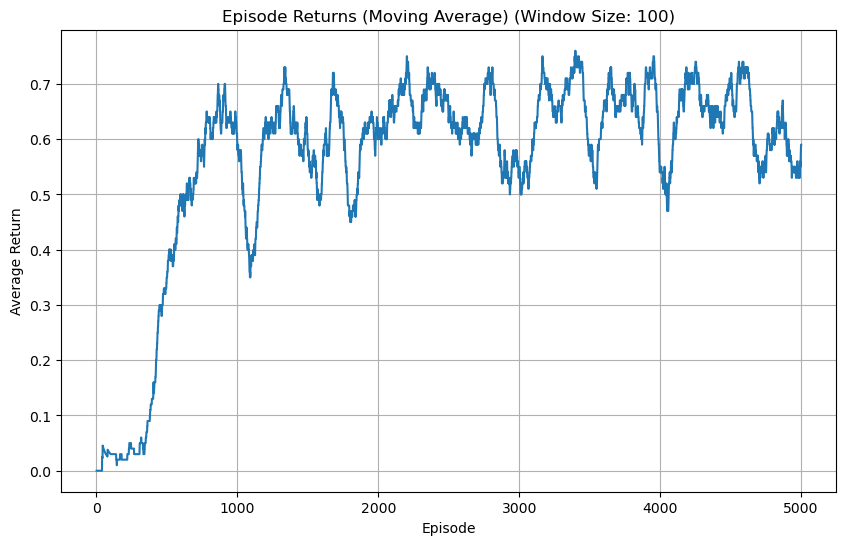

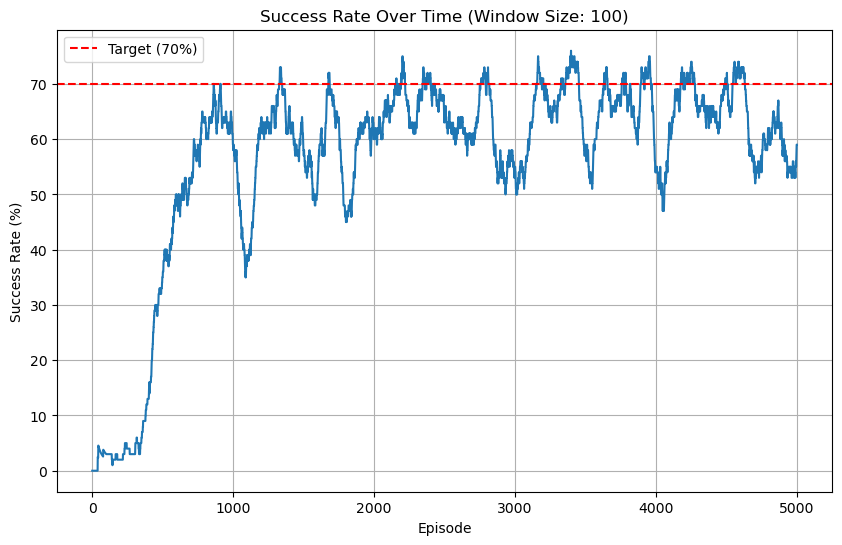

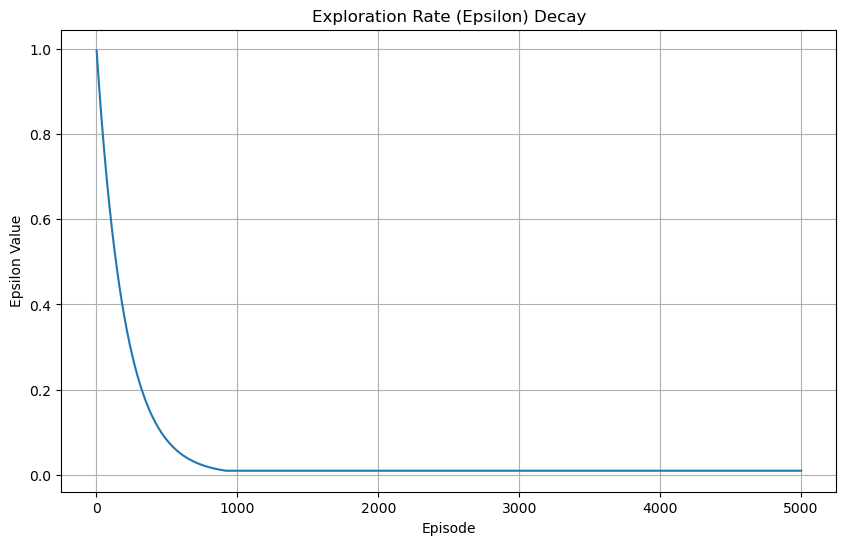

최종 성공률: 59.0%
목표 달성 여부: ✗ 미달


In [7]:
# 에피소드 번호 생성
episodes = list(range(1, len(training_stats['episode_rewards']) + 1))

# 1. 이동 평균 보상 곡선
plot_moving_average(
    episodes=episodes, 
    values=training_stats['episode_rewards'],
    window_size=100,
    title="Episode Returns (Moving Average)",
    ylabel="Average Return"
)

# 2. 성공률 곡선
# 윈도우 기반 성공률 계산
window_size = 100
success_rates = []
for i in range(len(training_stats['success_episodes'])):
    start_idx = max(0, i - window_size + 1)
    window_success_rate = np.mean(training_stats['success_episodes'][start_idx:i+1]) * 100
    success_rates.append(window_success_rate)

plt.figure(figsize=(10, 6))
plt.plot(episodes, success_rates)
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.title(f'Success Rate Over Time (Window Size: {window_size})')
plt.grid(True)
plt.axhline(y=70, color='r', linestyle='--', label='Target (70%)')
plt.legend()
plt.show()

# 3. ε 값 변화
plt.figure(figsize=(10, 6))
plt.plot(episodes, training_stats['epsilon_values'])
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Exploration Rate (Epsilon) Decay')
plt.grid(True)
plt.show()

print(f"최종 성공률: {training_stats['final_success_rate']:.1f}%")
print(f"목표 달성 여부: {'✓ 성공' if training_stats['final_success_rate'] >= 70 else '✗ 미달'}")

## 8. Q-Table 분석 및 시각화

=== Q-Table 분석 ===
Q-table 크기: (16, 4)
0이 아닌 Q-값 개수: 43
최대 Q-값: 0.686
최소 Q-값: 0.000



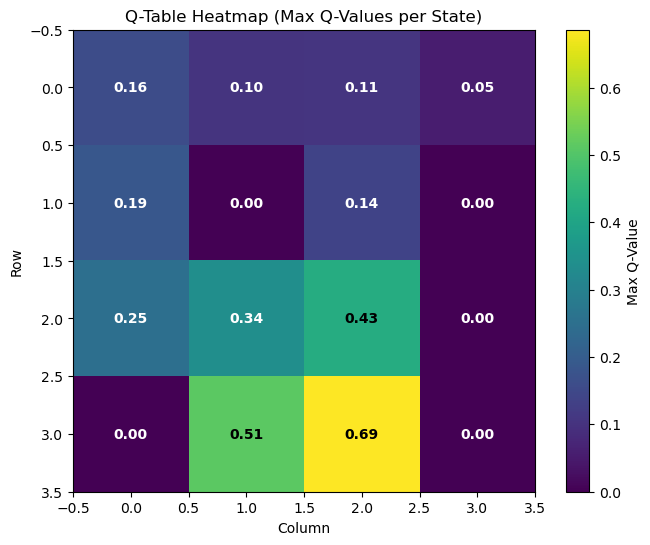

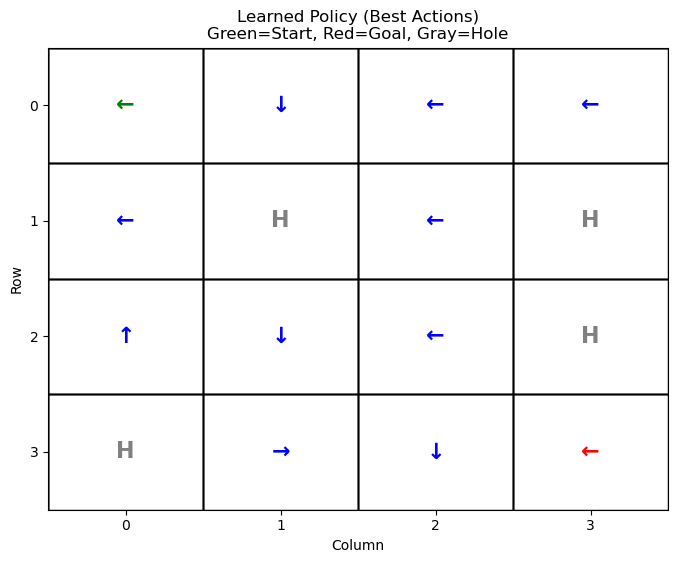

In [8]:
# Q-table 기본 정보
print("=== Q-Table 분석 ===")
print(f"Q-table 크기: {agent.q_table.shape}")
print(f"0이 아닌 Q-값 개수: {np.count_nonzero(agent.q_table)}")
print(f"최대 Q-값: {np.max(agent.q_table):.3f}")
print(f"최소 Q-값: {np.min(agent.q_table):.3f}")
print()

# 각 상태의 최대 Q-값 히트맵
max_q_values = np.max(agent.q_table, axis=1)
q_grid = max_q_values.reshape(4, 4)

plt.figure(figsize=(8, 6))
im = plt.imshow(q_grid, cmap='viridis')
plt.colorbar(im, label='Max Q-Value')
plt.title('Q-Table Heatmap (Max Q-Values per State)')

# 각 셀에 값 표시
for i in range(4):
    for j in range(4):
        state = i * 4 + j
        text = f'{max_q_values[state]:.2f}'
        plt.text(j, i, text, ha='center', va='center', 
                color='white' if max_q_values[state] < np.max(max_q_values)/2 else 'black',
                fontweight='bold')

plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

# 학습된 정책 시각화 (화살표)
policy = agent.get_policy()
action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

plt.figure(figsize=(8, 6))
for i in range(4):
    for j in range(4):
        state = i * 4 + j
        best_action = policy[state]
        arrow = action_arrows[best_action]
        
        # 특별한 상태 표시
        if state == 0:  # 시작점
            color = 'green'
        elif state == 15:  # 목표점
            color = 'red'
        elif state in [5, 7, 11, 12]:  # 구멍
            color = 'gray'
            arrow = 'H'  # Hole
        else:
            color = 'blue'
        
        plt.text(j, i, arrow, ha='center', va='center', 
                fontsize=16, fontweight='bold', color=color)
        
        # 격자 선
        plt.axhline(y=i-0.5, color='black', linewidth=1)
        plt.axvline(x=j-0.5, color='black', linewidth=1)

plt.axhline(y=3.5, color='black', linewidth=1)
plt.axvline(x=3.5, color='black', linewidth=1)

plt.xlim(-0.5, 3.5)
plt.ylim(-0.5, 3.5)
plt.gca().invert_yaxis()
plt.title('Learned Policy (Best Actions)\nGreen=Start, Red=Goal, Gray=Hole')
plt.xlabel('Column')
plt.ylabel('Row')
plt.xticks(range(4))
plt.yticks(range(4))
plt.show()

## 9. 하이퍼파라미터 실험

In [9]:
# 다양한 하이퍼파라미터 조합 실험
print("=== 하이퍼파라미터 실험 ===")

# 실험 설정
experiments = [
    {'name': 'Conservative', 'alpha': 0.1, 'gamma': 0.99, 'eps_decay': 0.998},
    {'name': 'Balanced', 'alpha': 0.1, 'gamma': 0.95, 'eps_decay': 0.995},
    {'name': 'Aggressive', 'alpha': 0.3, 'gamma': 0.95, 'eps_decay': 0.99},
    {'name': 'High_Discount', 'alpha': 0.1, 'gamma': 0.99, 'eps_decay': 0.995},
    {'name': 'Low_Learning', 'alpha': 0.05, 'gamma': 0.95, 'eps_decay': 0.995}
]

experiment_results = []

for exp in experiments:
    print(f"\n실험: {exp['name']}")
    print(f"α={exp['alpha']}, γ={exp['gamma']}, ε_decay={exp['eps_decay']}")
    
    # 환경 및 에이전트 생성
    env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=None)
    agent = QLearningAgent(
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
        learning_rate=exp['alpha'],
        discount_factor=exp['gamma'],
        epsilon_decay=exp['eps_decay']
    )
    
    # 훈련 (짧게)
    stats = train_q_learning(
        env=env, 
        agent=agent, 
        num_episodes=3000,
        verbose=False
    )
    
    experiment_results.append({
        'name': exp['name'],
        'params': exp,
        'final_success_rate': stats['final_success_rate'],
        'overall_success_rate': stats['overall_success_rate']
    })
    
    print(f"최종 성공률: {stats['final_success_rate']:.1f}%")
    env.close()

# 실험 결과 요약
print("\n=== 실험 결과 요약 ===")
print(f"{'실험명':<15} {'α':<6} {'γ':<6} {'ε_decay':<8} {'최종 성공률':<10} {'전체 성공률':<10}")
print("-" * 65)

for result in experiment_results:
    print(f"{result['name']:<15} "
          f"{result['params']['alpha']:<6} "
          f"{result['params']['gamma']:<6} "
          f"{result['params']['eps_decay']:<8} "
          f"{result['final_success_rate']:<10.1f} "
          f"{result['overall_success_rate']:<10.1f}")

# 최고 성능 찾기
best_experiment = max(experiment_results, key=lambda x: x['final_success_rate'])
print(f"\n🏆 최고 성능: {best_experiment['name']} ({best_experiment['final_success_rate']:.1f}%)")

=== 하이퍼파라미터 실험 ===

실험: Conservative
α=0.1, γ=0.99, ε_decay=0.998
최종 성공률: 62.0%

실험: Balanced
α=0.1, γ=0.95, ε_decay=0.995
최종 성공률: 60.0%

실험: Aggressive
α=0.3, γ=0.95, ε_decay=0.99
최종 성공률: 69.0%

실험: High_Discount
α=0.1, γ=0.99, ε_decay=0.995
최종 성공률: 64.0%

실험: Low_Learning
α=0.05, γ=0.95, ε_decay=0.995
최종 성공률: 2.0%

=== 실험 결과 요약 ===
실험명             α      γ      ε_decay  최종 성공률     전체 성공률    
-----------------------------------------------------------------
Conservative    0.1    0.99   0.998    62.0       43.2      
Balanced        0.1    0.95   0.995    60.0       49.6      
Aggressive      0.3    0.95   0.99     69.0       44.9      
High_Discount   0.1    0.99   0.995    64.0       56.3      
Low_Learning    0.05   0.95   0.995    2.0        2.8       

🏆 최고 성능: Aggressive (69.0%)


## 10. 모델 저장 및 로드

In [10]:
# 최고 성능 모델로 다시 훈련 (저장용)
print("=== 최종 모델 훈련 및 저장 ===")

# 최고 성능 설정으로 재훈련
best_params = best_experiment['params']
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=None)

final_agent = QLearningAgent(
    state_size=env.observation_space.n,
    action_size=env.action_space.n,
    learning_rate=best_params['alpha'],
    discount_factor=best_params['gamma'],
    epsilon_decay=best_params['eps_decay']
)

final_stats = train_q_learning(
    env=env,
    agent=final_agent,
    num_episodes=5000,
    verbose=True
)

env.close()

# Q-table 저장
if LOCAL_ENV:
    # 로컬 환경
    save_path = "../weights/q_table.npy"
    os.makedirs("../weights", exist_ok=True)
else:
    # Colab 환경
    save_path = "q_table.npy"

save_q_table(final_agent.q_table, save_path)

# 하이퍼파라미터와 결과도 함께 저장
metadata = {
    'hyperparameters': best_params,
    'final_success_rate': final_stats['final_success_rate'],
    'overall_success_rate': final_stats['overall_success_rate'],
    'training_episodes': 5000,
    'environment': 'FrozenLake-v1_4x4_slippery',
    'seed': SEED
}

metadata_path = save_path.replace('.npy', '_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"메타데이터 저장: {metadata_path}")
print(f"Q-table 크기: {final_agent.q_table.shape}")
print(f"저장된 파일 크기: {os.path.getsize(save_path)} bytes")

=== 최종 모델 훈련 및 저장 ===
Q-Learning 훈련 시작: 5000 에피소드
환경: FrozenLake-v1
하이퍼파라미터:
  학습률 (α): 0.3
  할인인수 (γ): 0.95
  초기 ε: 1.0
  최소 ε: 0.01
  ε 감쇠: 0.99



훈련 진행:  23%|██▎       | 1150/5000 [00:00<00:00, 5561.58it/s]


Episode 500/5000
  최근 500 에피소드 평균 보상: 0.040
  최근 100 에피소드 성공률: 8.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 3785

Episode 1000/5000
  최근 500 에피소드 평균 보상: 0.082
  최근 100 에피소드 성공률: 9.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 8002


훈련 진행:  34%|███▍      | 1707/5000 [00:00<00:00, 4308.99it/s]


Episode 1500/5000
  최근 500 에피소드 평균 보상: 0.152
  최근 100 에피소드 성공률: 20.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 15897


훈련 진행:  43%|████▎     | 2164/5000 [00:00<00:00, 3616.45it/s]


Episode 2000/5000
  최근 500 에피소드 평균 보상: 0.166
  최근 100 에피소드 성공률: 14.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 24942

Episode 2500/5000
  최근 500 에피소드 평균 보상: 0.386
  최근 100 에피소드 성공률: 50.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 38428


훈련 진행:  57%|█████▋    | 2859/5000 [00:00<00:00, 2485.72it/s]


Episode 3000/5000
  최근 500 에피소드 평균 보상: 0.490
  최근 100 에피소드 성공률: 42.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 53656


훈련 진행:  68%|██████▊   | 3375/5000 [00:01<00:00, 2162.36it/s]


Episode 3500/5000
  최근 500 에피소드 평균 보상: 0.510
  최근 100 에피소드 성공률: 43.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 69011


훈련 진행:  92%|█████████▏| 4609/5000 [00:01<00:00, 1787.44it/s]


Episode 4000/5000
  최근 500 에피소드 평균 보상: 0.494
  최근 100 에피소드 성공률: 52.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 85174

Episode 4500/5000
  최근 500 에피소드 평균 보상: 0.450
  최근 100 에피소드 성공률: 46.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 99668


훈련 진행: 100%|██████████| 5000/5000 [00:02<00:00, 2300.23it/s]


Episode 5000/5000
  최근 500 에피소드 평균 보상: 0.494
  최근 100 에피소드 성공률: 38.0%
  현재 ε: 0.010
  방문한 상태 수: 11
  총 업데이트 횟수: 116552

=== 훈련 완료 ===
최종 성공률 (최근 100): 38.0%
전체 성공률: 32.6%
최종 ε: 0.010
총 방문 상태: 11/16
총 Q-table 업데이트: 116552
Q-table saved to q_table.npy
메타데이터 저장: q_table_metadata.json
Q-table 크기: (16, 4)
저장된 파일 크기: 640 bytes


## 11. 저장된 모델 로드 및 검증

In [11]:
# 저장된 Q-table 로드
print("=== 저장된 모델 로드 및 검증 ===")

loaded_q_table = load_q_table(save_path)

# 로드된 Q-table과 원본 비교
print(f"로드된 Q-table 크기: {loaded_q_table.shape}")
print(f"원본과 동일한가: {np.array_equal(final_agent.q_table, loaded_q_table)}")

# 메타데이터 로드
with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print(f"\n저장된 모델 정보:")
print(f"  최종 성공률: {loaded_metadata['final_success_rate']:.1f}%")
print(f"  훈련 에피소드: {loaded_metadata['training_episodes']}")
print(f"  하이퍼파라미터: {loaded_metadata['hyperparameters']}")

=== 저장된 모델 로드 및 검증 ===
Q-table loaded from q_table.npy
로드된 Q-table 크기: (16, 4)
원본과 동일한가: True

저장된 모델 정보:
  최종 성공률: 38.0%
  훈련 에피소드: 5000
  하이퍼파라미터: {'name': 'Aggressive', 'alpha': 0.3, 'gamma': 0.95, 'eps_decay': 0.99}


## 12. 학습된 정책 평가

In [12]:
def evaluate_policy(q_table, env, num_episodes=100, verbose=True):
    """
    학습된 정책 평가 (greedy 정책만 사용)
    """
    successes = 0
    total_rewards = 0
    episode_lengths = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        steps = 0
        
        while steps < 100:  # 최대 스텝 제한
            # Greedy 행동 선택 (탐험 없음)
            q_values = q_table[state]
            action = np.random.choice(np.where(q_values == np.max(q_values))[0])
            
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
        
        if episode_reward > 0:
            successes += 1
        
        total_rewards += episode_reward
        episode_lengths.append(steps)
    
    success_rate = (successes / num_episodes) * 100
    avg_reward = total_rewards / num_episodes
    avg_length = np.mean(episode_lengths)
    
    if verbose:
        print(f"\n=== 정책 평가 결과 ({num_episodes} 에피소드) ===")
        print(f"성공률: {success_rate:.1f}% ({successes}/{num_episodes})")
        print(f"평균 보상: {avg_reward:.3f}")
        print(f"평균 에피소드 길이: {avg_length:.1f} 스텝")
    
    return {
        'success_rate': success_rate,
        'average_reward': avg_reward,
        'average_length': avg_length,
        'num_episodes': num_episodes
    }

# 학습된 정책 평가
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=None)
evaluation_results = evaluate_policy(loaded_q_table, env, num_episodes=1000)
env.close()

# 무작위 정책과 비교
print("\n=== 무작위 정책과 비교 ===")
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=None)
random_successes = 0
for _ in range(1000):
    state, _ = env.reset()
    done = False
    steps = 0
    while not done and steps < 100:
        action = env.action_space.sample()  # 무작위 행동
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        steps += 1
        if reward > 0:
            random_successes += 1
            break

random_success_rate = (random_successes / 1000) * 100
env.close()

print(f"무작위 정책 성공률: {random_success_rate:.1f}%")
print(f"학습된 정책 성공률: {evaluation_results['success_rate']:.1f}%")
print(f"개선 정도: {evaluation_results['success_rate'] / random_success_rate:.1f}배")

# 목표 달성 여부
target_success_rate = 70
print(f"\n목표 달성 여부 (>= {target_success_rate}%): ", end="")
if evaluation_results['success_rate'] >= target_success_rate:
    print("✅ 성공!")
else:
    print("❌ 미달")


=== 정책 평가 결과 (1000 에피소드) ===
성공률: 60.8% (608/1000)
평균 보상: 0.608
평균 에피소드 길이: 36.0 스텝

=== 무작위 정책과 비교 ===
무작위 정책 성공률: 1.2%
학습된 정책 성공률: 60.8%
개선 정도: 50.7배

목표 달성 여부 (>= 70%): ❌ 미달


## 13. 정책 시연

In [13]:
def demonstrate_policy(q_table, num_episodes=3, render_mode="rgb_array"):
    """
    학습된 정책을 시각적으로 시연
    """
    env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode=render_mode)
    action_names = ['Left', 'Down', 'Right', 'Up']
    
    print(f"=== 학습된 정책 시연 ({num_episodes} 에피소드) ===")
    
    for episode in range(num_episodes):
        print(f"\n--- Episode {episode + 1} ---")
        state, _ = env.reset()
        print(f"시작 상태: {state}")
        
        episode_reward = 0
        step = 0
        
        while step < 100:
            # Greedy 행동 선택
            q_values = q_table[state]
            action = np.random.choice(np.where(q_values == np.max(q_values))[0])
            
            print(f"Step {step + 1}: State {state}, Action {action} ({action_names[action]}), Q-values: {q_values}")
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            
            print(f"         → Next state: {next_state}, Reward: {reward}")
            
            state = next_state
            step += 1
            
            if terminated or truncated:
                break
        
        result = "SUCCESS" if episode_reward > 0 else "FAILED"
        print(f"Episode result: {result} (Total reward: {episode_reward}, Steps: {step})")
    
    env.close()

# 정책 시연 실행
demonstrate_policy(loaded_q_table, num_episodes=2)

=== 학습된 정책 시연 (2 에피소드) ===

--- Episode 1 ---
시작 상태: 0
Step 1: State 0, Action 0 (Left), Q-values: [0.06243362 0.06163811 0.05748968 0.06172199]
         → Next state: 0, Reward: 0
Step 2: State 0, Action 0 (Left), Q-values: [0.06243362 0.06163811 0.05748968 0.06172199]
         → Next state: 0, Reward: 0
Step 3: State 0, Action 0 (Left), Q-values: [0.06243362 0.06163811 0.05748968 0.06172199]
         → Next state: 4, Reward: 0
Step 4: State 4, Action 0 (Left), Q-values: [0.09662472 0.06845349 0.05806679 0.07302859]
         → Next state: 0, Reward: 0
Step 5: State 0, Action 0 (Left), Q-values: [0.06243362 0.06163811 0.05748968 0.06172199]
         → Next state: 0, Reward: 0
Step 6: State 0, Action 0 (Left), Q-values: [0.06243362 0.06163811 0.05748968 0.06172199]
         → Next state: 4, Reward: 0
Step 7: State 4, Action 0 (Left), Q-values: [0.09662472 0.06845349 0.05806679 0.07302859]
         → Next state: 8, Reward: 0
Step 8: State 8, Action 3 (Up), Q-values: [0.10502694 0.1139649